# Goal: Create customer profiles using clustering methods and customer purchase history

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

import wrangle_profiles as wp
import explore_profiles as ep


##  Wrangle

The original data contained transaction information for LGS customers from 2001-2004. Items purchased in ‘purchase’ transactions were sorted into one of nine categories. <br>
<br>
Central categories representing major gaming interests include:
* Board Games 
* Role Playing Games
* Trading Card Games
* Tabletop Minis Games
* Modeling Supplies
<a/>

Support Categories represent categories that support or are adjacent to major interests include:
* Accessories
* Concessions
* Game Room Rentals
<a/>

Items that could not be classified were categorized as 
* Other
<a/>

In [2]:
df = wp.get_prepared_profiles_data()

## Explore 

### What does an average customer's spending habits look like?

Given the mean and relatively large standard deviation across all categories, penning down the habbits of an 'average' would be unhelpful due to the large variance. Moving forward it will be my goal to identify population clusters were the variance is less severe.

In [3]:
ep.get_desc(df)

,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games,game_room_rental,net_sales
mean,1.715006,0.474149,4.362547,1.569987,0.165826,0.541614,2.228247,0.059899,172.634332
std,4.503849,1.391602,18.823379,8.263589,0.877833,2.303441,7.990032,0.564630,442.719224


### How many customers does each category appeal to? 

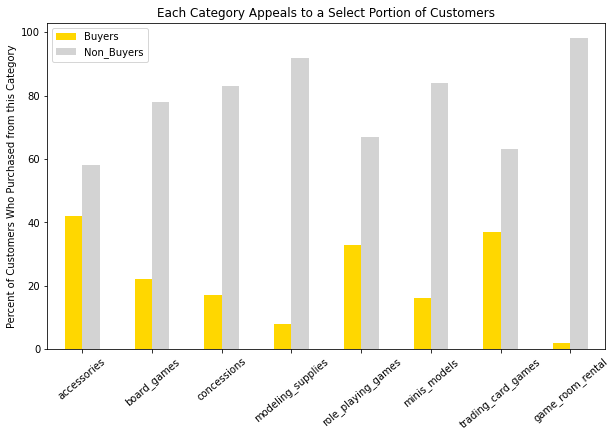

In [4]:
ep.cat_appeal(df)

Each category only appeals to a select amount of customers:
    
Major Categories
* Trading Card Games 37%
* Role Playing Games 33%
* Board Games 22%
* Minis Models 16%
* Modeling Supplies 8%

Support Categories
* Accessories 42%
* Concessions 17%
* Game Room Rental 2%

Major categories appeal to roughly 1/3 of customers or less, likely due to specialized interests of customers <br>
Accesories is the highest apeal category likely do to supporting multiple interests tied to major categories

### Is there a relationship between customers who buy products in one category and customers who buy products in a differint category?

Based on a chi-square test, using an alpha of .05, and the odds ratio of buyers to non-buyers in each category the following relationships exist between these categories:

Customers who bought Board Games
* 78% More likely to buy role playing games
* 61% Less likely to buy trading card games 

Customers who bought Role Playing Games
* 4.23 Times as likely to buy minis models
* 2.59 Times as likely to buy accessories
* 2.21 Times as likely to buy modeling supplies
* 78% More likely to buy board games
* 80% More likely to buy concessions
* 40% decreased odds of buying trading card games

Customers who bought Minis Models
* 8.45 Times as likely to buy modeling supplies
* 4.23 Times as likely to buy Role Playing Games
* 75% More likely to to buy concessions
* 50% Less likely to buy trading card games

Customers who bought Trading Card Games
* 88% More likely to buy accessories
* 47% More likely to buy concessions
* 61% Less likely to buy board games
* 61% Less likely to buy modeling supplies
* 50% Less likely to buy minis models 
* 40% Less likely to buy role playing games

Customers who bought Modeling Supplies
* 8.45 Times as likely to buy minis models
* 2.21 Times as likely to buy role playing games
* 88% increased odds of buying accessories
* 65% More likely to buy concessions
* 61% less likely to buy Trading Card Games 

#### Summary of Major Categories

Board Gamers
* Diversified Interests, not many strong relationships to other categories
* More likely to buy role playing games
* Less likely buy trading card games

Trading Card Gamers
* On their own island, less likely to engage in other major categories
* More likely to buy accessories and concessions

Role Playing Gamers
* Likely a major driver of sales in other categories
* Nearly 3 times as likely to buy accessories
* Over 4 times as likely to buy minis models 
* 2 times as likely to buy modeling supplies
* More likely to buy board games and concessions
* Less likely to buy trading card games

Minis Models
* Comprised of “war gaming” models and models that support role playing games
* Likely a driver of modeling supplies and partially driven by role playing games
* Over 8 times as likely to buy modeling supplies
* More likely to buy concessions
* Less likely to buy trading card games

Modeling supplies
* Likely driven by minis models
* Over 8 times as likely to buy minis models


 #### Category Relationship Tests

In [5]:
ep.get_rel(df)

bought_accessories and bought_concessions
--------------------------------------------------------
Chi-Square P-Value: 0.00022898142106283562
Odds Ratio: 1.49

bought_accessories and bought_role_playing_games
--------------------------------------------------------
Chi-Square P-Value: 2.637590995781412e-07
Odds Ratio: 2.59

bought_accessories and bought_trading_card_games
--------------------------------------------------------
Chi-Square P-Value: 2.6189298764791124e-09
Odds Ratio: 1.88

bought_board_games and bought_role_playing_games
--------------------------------------------------------
Chi-Square P-Value: 0.003992273243111018
Odds Ratio: 1.78

bought_board_games and bought_trading_card_games
--------------------------------------------------------
Chi-Square P-Value: 3.903131004282979e-11
Odds Ratio: 0.39

bought_concessions and bought_modeling_supplies
--------------------------------------------------------
Chi-Square P-Value: 0.0002876863942808126
Odds Ratio: 1.65

bought_conc

### Is there a relationship between major groups and customer spending?


Buyer groups are showing a large amount af variation within each group. <br>
Overall net sales contains a large number of extream outlier. <br>
These outliers could account for the large amount of variance in the data.

In [6]:
ep.get_sales(df)

,total,accessories,board_games,concessions,modeling_supplies,role_playing_games,minis_models,trading_card_games
Customers,1586,667,347,531,274,134,254,585
Mean Sales,172,291,332,318,346,465,427,304
Standard Deviation Sales,442,640,753,712,751,891,865,665


* Mean net sales accross groups range from 219 to 465 showing a difference of 246 in mean net spending at the most extream values
* Standard deviatin in net sales is about 2 times the mean in each category
* This suggests a large spread in the data suggesting that there are many extream outliers in each group
* Given that categories overlap and all categories show a higher than total mean net sales it is likely that high outliers existing in multiple categories are skewing the mean of each category resulting in higher means due to being divided by fewer customers in each subgroup

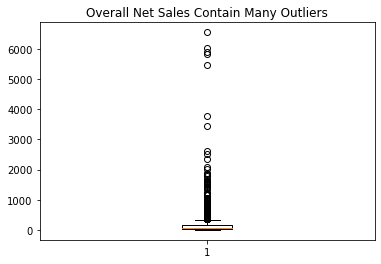

In [7]:
plt.boxplot(df.net_sales)
plt.title("Overall Net Sales Contain Many Outliers")
plt.show()

* Given the extream outliers found in net sales I have elected to section off customers with exceptinally high net spending into a seperate group using an IQR of 1.5 designated high spenders
* Customers with net spending more than 1.5 times the IQR higher than the 75th percentile are designated high spenders
* Other customers are designated moderate spenders

In [8]:
q1 = df.net_sales.quantile(.25)
q3 = df.net_sales.quantile(.75)

iqr = q3 - q1

upper = q3 + (1.5 * iqr)

df_mod = df[(df.net_sales <= upper)]
df_high = df[(df.net_sales > upper)]

print(len(df))
print(len(df_mod))
print(len(df) - len(df_mod))

1586
1419
167


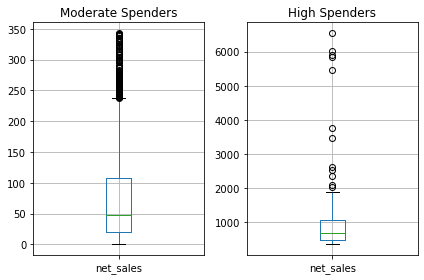

In [9]:
# Create subplots
fig, axs = plt.subplots(1, 2) 

# Plot the first box plot
df_mod.boxplot(column='net_sales', ax=axs[0])
axs[0].set_title('Moderate Spenders')

# Plot the second box plot
df_high.boxplot(column='net_sales', ax=axs[1])
axs[1].set_title('High Spenders')

plt.tight_layout() 
plt.show()

Moderate Spenders Group
* Contains many outliers
* Outliers seep evenly distributed
* Range is much narrower than overall group helping to pain a clearer picture

High Spenders
* High spenders show a large amount of variation
* There is some clustering of outliers around 6,000 and between 3,000 and 2,000



### How do differnt spending groups effect total sales?

In [10]:
mod_count = len(df_mod)
high_count = len(df_high)
all_count = len(df)

mod_mean_sales = df_mod.mean()
high_mean_sales = df_high.mean()

mod_pcust = round(mod_count / all_count, 2) * 100
high_pcust = round(high_count / all_count, 2) * 100

mod_sales = df_mod.net_sales.sum()
high_sales = df_high.net_sales.sum()

tot_sales = df.net_sales.sum()
mod_psales = round(mod_sales / tot_sales, 2) * 100
high_psales = round(high_sales / tot_sales, 2) * 100


print(f'Moderate Spenders represent {mod_pcust}% of total customers and {mod_psales}% of total net sales')
print(f'High Spenders represent {high_pcust}% of total customers and {high_psales}% of total net sales')

Moderate Spenders represent 89.0% of total customers and 40.0% of total net sales
High Spenders represent 11.0% of total customers and 60.0% of total net sales


### How do product category groups effect customer spending?

In [11]:
ep.get_major_sales(df_mod)

,total,board_games,modeling_supplies,role_playing_games,minis_models,trading_card_games
Customers,1419,278,212,98,183,468
Mean Sales,76,111,99,129,109,103
Standard Deviation Sales,76,79,86,80,87,88


In [12]:
ep.get_major_sales(df_high)

,total,board_games,modeling_supplies,role_playing_games,minis_models,trading_card_games
Customers,167,69,62,36,71,117
Mean Sales,987,1223,1194,1380,1245,1108
Standard Deviation Sales,1036,1363,1249,1349,1321,1175


* Customers who buy trading card gamee makeup 70% of high spending group
* Customers who buy role playing games spend more on average than any other group.
* Customers who buy role playing games are also the smallest customer group.

# Conclution